In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import find_peaks
from data_access import metadata_from_path

Finding statistical measures from the dataset

In [2]:
data_path = 'data/2/exp02H20141204_17h28.csv'
FISH_ATTR_COUNT = 3 # how manny bits of info for each fish

experement = pd.read_csv(data_path)
a = experement.iloc[31000:,:]


print(a.head(5))

             X1        Y1        H1        X2        Y2        H2
31000  95.89994  310.4725 -204.5278  14.61787  271.4049 -198.0561
31001  95.37074  310.5196 -204.5161  13.35791  271.4748 -198.0515
31002  94.24655  310.8535 -204.5027  11.90850  271.7569 -198.0579
31003  93.90428  310.8884 -204.4952  10.61782  271.9382 -198.0679
31004  93.21094  311.1387 -204.5098   8.83675  272.0749 -198.0566


In [3]:
n_fish = experement.shape[1]//FISH_ATTR_COUNT
cols = [i+2 for i in range(0,n_fish*FISH_ATTR_COUNT,FISH_ATTR_COUNT)]
headings = a.iloc[:, cols]
print(headings.describe())

                  H1             H2
count  176826.000000  174201.000000
mean     -491.745612    -462.815447
std       223.375882     188.195076
min      -881.130200    -767.319900
25%      -681.736325    -627.988500
50%      -501.115400    -495.781800
75%      -282.852950    -305.932900
max      -152.695100    -166.149700


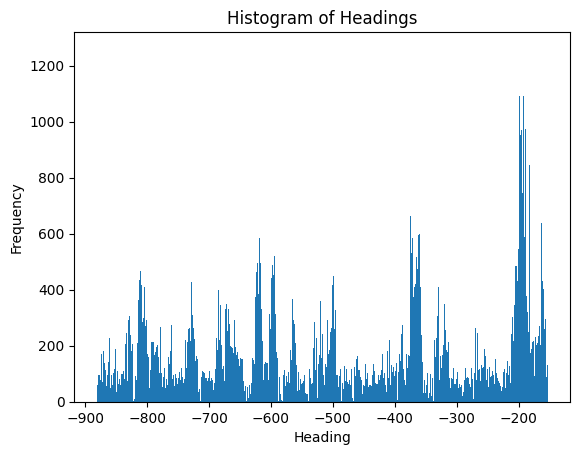

In [4]:

plt.hist(headings["H1"], bins=1000)
plt.xlabel("Heading")
plt.ylabel("Frequency")
plt.title("Histogram of Headings")
plt.show()

Fig 1

               X1          Y1          H1          X2          Y2          H2
count  710.000000  710.000000  710.000000  710.000000  710.000000  710.000000
mean    10.701123  -31.538931 -209.885655   55.511549  -51.429348 -209.841270
std    211.956828  204.756438    1.649193  216.123540  196.466624    1.528144
min   -328.759300 -273.285200 -213.018200 -301.475200 -312.080700 -212.655400
25%   -196.506375 -230.279800 -211.047775 -137.570550 -232.093050 -211.055100
50%     61.736170  -62.864525 -210.283850  115.839050  -91.050705 -209.697250
75%    218.758350  174.831950 -208.585075  255.425500  112.383525 -208.994600
max    271.263500  310.161300 -206.390600  321.467800  288.627100 -206.733700
Differance in heading after one lap 2.1096306016716913π


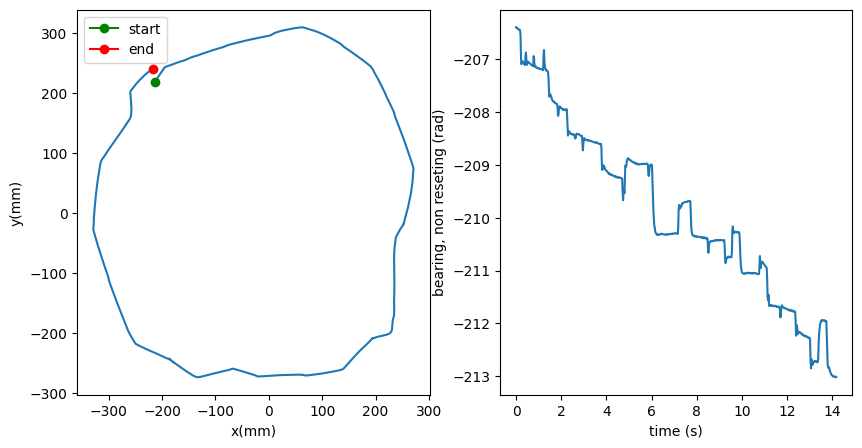

In [5]:

fps = metadata_from_path(data_path)['Fps']

a_onelap = a.iloc[33000:33710, :]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))   

ax1.plot(a_onelap.iloc[:,0], a_onelap.iloc[:,1])
ax1.plot(a_onelap.iloc[0,0], a_onelap.iloc[0,1],marker = "o", color = "green", label = "start")
ax1.plot(a_onelap.iloc[-1,0], a_onelap.iloc[-1,1], marker = "o", color = "red", label = "end")
ax1.set_xlabel("x(mm)")
ax1.set_ylabel("y(mm)")
ax1.legend()

ax2.plot(np.arange(len(a_onelap.iloc[:,2]))/fps, a_onelap.iloc[:,2])
ax2.set_xlabel("time (s)")
ax2.set_ylabel("bearing, non reseting (rad)")

print(a_onelap.describe())
differance = abs(a_onelap["H1"].max()-a_onelap["H1"].min())
print(f"Differance in heading after one lap {differance/math.pi}π")

plt.show()

Fig 2

Trying to use a normal distibutiona and signifiance level to identiy turns. 

In [6]:

turn_rate = headings["H1"].diff() * fps

mu = turn_rate.mean()
std = turn_rate.std()

#Bounds = mu +- Z * std
#At 5% significance level, Z = 19.6 (two tailed)

lower_bound = mu - 1.96*std
upper_bound = mu + 1.96*std

turn_events = turn_rate[(turn_rate < lower_bound) | (turn_rate > upper_bound)]

print(turn_events)

31044     10.135
31045     13.855
31085      6.785
31105      9.595
31106     13.220
           ...  
207749    -9.780
207770   -10.390
207792     8.345
207813    14.045
207814    12.905
Name: H1, Length: 11854, dtype: float64


Text(0, 0.5, 'Value of time diffs')

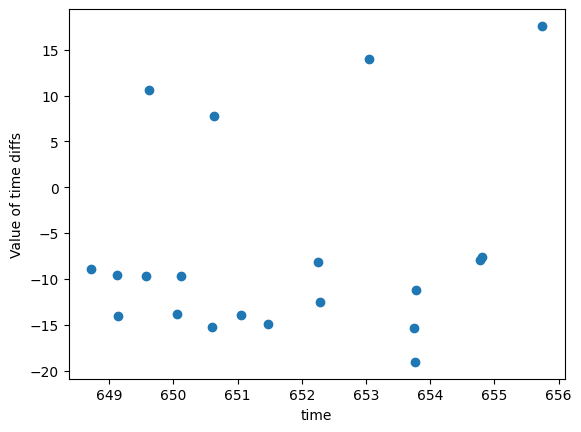

In [7]:
section_range = slice(100, 120)

frames = turn_events.index.to_numpy()
time = frames/fps

turn_diffs = turn_events.values

plt.scatter(time[section_range], turn_diffs[section_range])
plt.xlabel('time')
plt.ylabel("Value of time diffs")

Finds too many. At 55 SigLvl, 5% of frames will be a turn or 2.5 turns a second. 

Alternative method (suggested by Gemini) is uing a differance over a moving window i.e. 

In [21]:
window_size = 150

sustained_turn = headings['H1'].diff(periods=window_size)

turn_threshold = np.pi

significant_events = sustained_turn[abs(sustained_turn) > turn_threshold]

print(max(significant_events))
print(significant_events[32420])
print(sustained_turn[32420])
print(type(sustained_turn))

8.144600000000082
-3.385300000000001
-3.385300000000001
<class 'pandas.core.series.Series'>


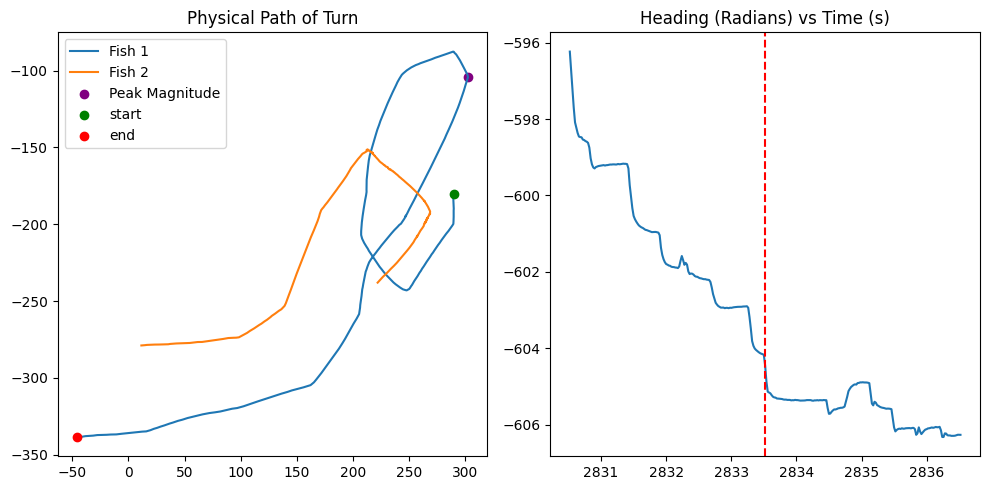

In [9]:
turn_idx = sustained_turn.abs().idxmax()

window = a.loc[turn_idx-window_size : turn_idx+window_size]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(window['X1'], window['Y1'], label='Fish 1')
plt.plot(window['X2'], window['Y2'], label='Fish 2')

plt.scatter(a.loc[turn_idx, 'X1'], a.loc[turn_idx, 'Y1'], color='purple', label='Peak Magnitude')

plt.scatter(window.iloc[0]['X1'], window.iloc[0]['Y1'], marker="o", color="green", label="start", zorder=5)
plt.scatter(window.iloc[-1]['X1'], window.iloc[-1]['Y1'], marker="o", color="red", label="end", zorder=5)

plt.title("Physical Path of Turn")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(window.index / fps, window['H1'])
plt.axvline(turn_idx / fps, color='red', linestyle='--')
plt.title("Heading (Radians) vs Time (s)")

plt.tight_layout()
plt.show()

significant_events contains all the frames where the over the past "window_size' there was a change of 180degrees or pi radians.
Given a fps of 50 and 150 frame window this is looking over 3 seconds. Given one full lap takes around 14s (fig 2), this shoud only find abnormily fast changes in direction, idealy u turns. 

This still leaves the issue of finding the point of greatest turn within these events. 

In [18]:
#Help from gemini, have read thru documentation but not verified as of 17/02/26 16:24

peaks, _ = find_peaks(sustained_turn.abs().fillna(0), 
                      height=np.pi, 
                      distance=150)
print(f"Before, find_peaks applied, {len(sustained_turn)} turns found")
print(f"After, found {len(peaks)} unique turn events.")
#Result seems to make sense

[  1457   3106   7691  11406  13802  14323  14811  15011  15177  16735
  19685  20019  20350  21020  21574  22221  22922  23676  24835  25341
  26475  26769  30006  30667  31327  32055  32513  32744  39474  40170
  41350  41555  41765  42064  42819  48705  50237  52389  53753  54369
  54610  54906  55276  56763  57835  58006  58171  58453  58835  60177
  60516  60794  61991  62206  62628  63091  63985  64348  65124  65957
  66159  66464  66690  66966  67171  67407  67607  68074  69060  70298
  70811  72021  72651  72904  73605  75237  75413  76413  76837  77070
  77318  77996  78372  78699  78903  79053  79649  80000  82181  82758
  84232  84543  87042  88400  88672  89608  90233  91057  91337  91614
  92955  93425  94172  94338  94654  94815  95048  95236  95595  95997
  97059  97527  97984  98600  99213 100530 101062 101580 102398 102865
 103537 103780 104115 105043 105240 105637 106086 106272 106641 107113
 107342 107642 108026 108188 108414 109399 109549 109909 110391 110676
 11101

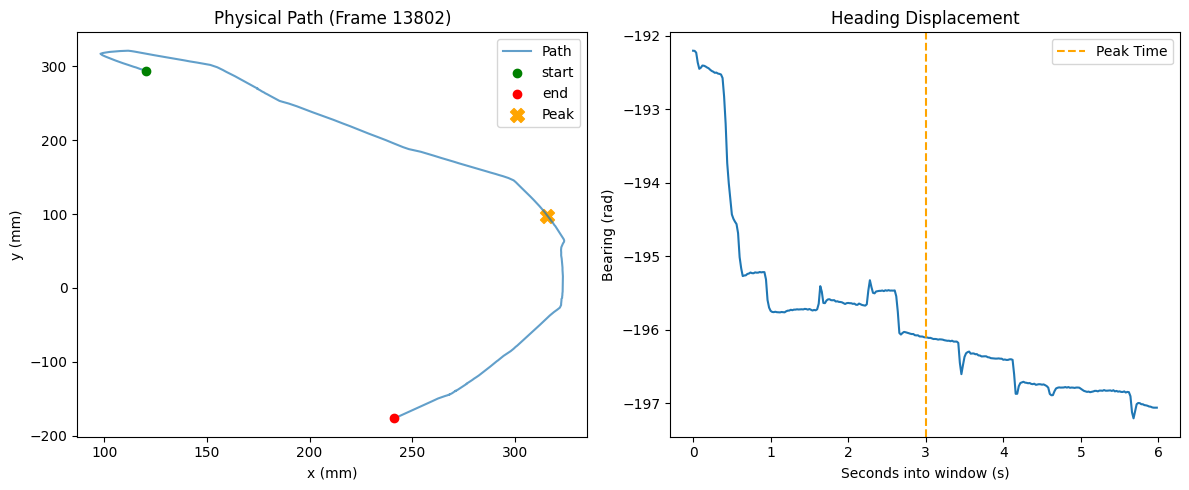

In [13]:
def plot_path_and_bearings(df: pd.DataFrame, index: int, window: int = 150, fps:int = fps):
    start_idx = max(0, index - window)
    end_idx = min(len(df), index + window)
    plotting_range = slice(start_idx, end_idx)
    
    sub_df = df.iloc[plotting_range]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(sub_df.iloc[:, 0], sub_df.iloc[:, 1], label="Path", alpha=0.7)
    
    ax1.scatter(sub_df.iloc[0, 0], sub_df.iloc[0, 1], color="green", label="start", zorder=5)
    ax1.scatter(sub_df.iloc[-1, 0], sub_df.iloc[-1, 1], color="red", label="end", zorder=5)
    
    ax1.scatter(df.iloc[index, 0], df.iloc[index, 1], color="orange", marker="X", s=100, label="Peak")
    
    ax1.set_xlabel("x (mm)")
    ax1.set_ylabel("y (mm)")
    ax1.set_title(f"Physical Path (Frame {index})")
    ax1.legend()

    local_time = np.arange(len(sub_df)) / fps 
    
    # Extract the heading column (H1 is index 2)
    heading_values = sub_df.iloc[:, 2].values 
    
    ax2.plot(local_time, heading_values)
    
    # Mark the peak relative to the start of this window
    peak_relative_time = (index - start_idx) / fps
    ax2.axvline(peak_relative_time, color='orange', linestyle='--', label="Peak Time")
    
    ax2.set_xlabel("Seconds into window (s)")
    ax2.set_ylabel("Bearing (rad)")
    ax2.set_title("Heading Displacement")
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_path_and_bearings(a, peaks[4])

This mostly works but sometimes such as the third "peak' is just because the fish makes a weird movement. Not sure how to fix. 

In [40]:
from data_access import get_experement_paths

paths = get_experement_paths(group_size = 2)

path = pd.read_csv(paths[0])

def find_significant_events(experement:pd.DataFrame, window_size:int = 150, turn_threshold:float = np.pi):
    '''
    Filters arrays of the signifiacnt turn events and the angle (rad) of turn over the window. 

    experement : pd.DataFrame
        The raw data incluing column headings. 
    window_size : int, optional
        The number of frames over which to calculate the turn (default is 150).
    turn_threshold : float, optional
        The radian value a turn must exceed to be 'significant' (default is pi).

    Retruns:
    pd.DataFrame
        A dataframe of sustained turn values, keeping only the 'significant' rows.
        The original frame indices from the input are preserved.
    '''
    headings = experement.iloc[:,2::3]
 
    sustained_turn = headings.diff(periods=window_size)

    filter = (sustained_turn.abs() > turn_threshold).any(axis=1)

    return sustained_turn[filter]

significant_events = find_significant_events(path)
print(significant_events.shape)
print(significant_events.head(5))
print(type(significant_events))


(4806, 2)
           H1        H2
512  0.003270 -3.180343
513  0.002416 -3.246619
514  0.001556 -3.242455
515 -0.003390 -3.234891
516 -0.000979 -3.231716
<class 'pandas.core.frame.DataFrame'>


In [42]:
def find_peaks_from_significant_events(significant_events):

    all_peaks = (
    significant_events
    .apply(lambda x: find_peaks(x.abs().fillna(0), height=np.pi, distance=150)[0])
    .explode()
    .reset_index()
    )
    all_peaks.columns = ['column_name', 'peak_index']

    return all_peaks

peaks = find_peaks_from_significant_events(significant_events)
print(type(peaks))
print(peaks.shape)
print(peaks)

<class 'pandas.core.frame.DataFrame'>
(43, 2)
   column_name peak_index
0           H1        362
1           H1        521
2           H1        748
3           H1        902
4           H1       1102
5           H1       1365
6           H1       1535
7           H1       1768
8           H1       1949
9           H1       2118
10          H1       2269
11          H1       2425
12          H1       2624
13          H1       2787
14          H1       2971
15          H1       3142
16          H1       3298
17          H1       3523
18          H1       3685
19          H1       3901
20          H1       4055
21          H1       4276
22          H1       4479
23          H1       4733
24          H2         87
25          H2        688
26          H2        859
27          H2       1075
28          H2       1295
29          H2       1589
30          H2       2017
31          H2       2198
32          H2       2410
33          H2       2653
34          H2       2817
35          H2    

IDEA
- find corrolation between H2 and H1 for different turn thresholds and window sizes to get best values. (dosnt work)

- time-lagged cross-corralation, would act on the (unfiltereed) sustained turn data.
 - https://www.youtube.com/watch?v=dKDgihvtZGk
 - https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.ccf.html
 - https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_ccf.html


In [46]:
paths = get_experement_paths(group_size = 2)

path = pd.read_csv(paths[0])

headings = experement.iloc[:,2::3]

sustained_turn = headings.diff(periods=window_size)

lags = np.arange(-100,100)

cross_corr = [sustained_turn["H1"].corr(sustained_turn["H2"].shift(lag)) for lag in lags]

best_lag = lags[np.argmax(cross_corr)]

print(best_lag)

10


In [54]:
paths = get_experement_paths(group_size = 2)

window_sizes = np.arange(175, 400)
lags = np.arange(-100, 100)

best_results_in_paths = []

for path in paths:
    best_window_size = None
    best_lag = None
    best_correlation = -1

    path_csv = pd.read_csv(path)
    headings = path_csv.iloc[:,2::3]

    for window_size in window_sizes:
        
        sustained_turn = headings.diff(periods=window_size)
        
        for lag in lags:

            cross_corr = sustained_turn["H1"].corr(sustained_turn["H2"].shift(lag))
            
            # 3. Update if better
            if cross_corr > best_correlation:
                best_correlation = cross_corr
                best_lag = lag
                best_window_size = window_size

    best_results_in_paths.append((best_correlation,best_lag,best_window_size))

print(best_results_in_paths)

[(np.float64(0.8133622356946849), np.int64(10), np.int64(399)), (np.float64(0.7139596900216686), np.int64(-10), np.int64(399)), (np.float64(0.5712927045249668), np.int64(-20), np.int64(399)), (np.float64(0.8404526795039741), np.int64(-38), np.int64(399)), (np.float64(0.6446083736874949), np.int64(9), np.int64(399)), (np.float64(0.8907236975441347), np.int64(44), np.int64(399)), (np.float64(0.634321084310125), np.int64(-86), np.int64(399)), (np.float64(0.5935536193626172), np.int64(16), np.int64(399)), (np.float64(0.4886095349062089), np.int64(69), np.int64(399)), (np.float64(0.6572135617401764), np.int64(5), np.int64(399))]


In [55]:
#when window_size was set between 1 and 200 ()
'''
[[  0.77248418  -4.         199.        ]
 [  0.61197755 -14.         199.        ]
 [  0.48452243 -17.         199.        ]
 [  0.77138746 -28.         199.        ]
 [  0.55500128   9.         199.        ]
 [  0.81096171  27.         199.        ]
 [  0.47869719 -98.         199.        ]
 [  0.50086965  16.         199.        ]
 [  0.37462407  30.         199.        ]
 [  0.58682914   1.         199.        ]]
'''
results_array = np.array(best_results_in_paths)

mean_lag = sum(results_array[:,1])/len(results_array[:,1])
mean_window = sum(results_array[:,2])/len(results_array[:,2])
print(results_array)
print(mean_lag, mean_window)

[[  0.81336224  10.         399.        ]
 [  0.71395969 -10.         399.        ]
 [  0.5712927  -20.         399.        ]
 [  0.84045268 -38.         399.        ]
 [  0.64460837   9.         399.        ]
 [  0.8907237   44.         399.        ]
 [  0.63432108 -86.         399.        ]
 [  0.59355362  16.         399.        ]
 [  0.48860953  69.         399.        ]
 [  0.65721356   5.         399.        ]]
-0.1 399.0


In [56]:
paths = get_experement_paths(group_size = 2)
path_csv = pd.read_csv(paths[1])
headings = path_csv.iloc[:,2::3]

velocity = headings.diff(periods=5)

rolling_windows = np.arange(25, 151, 5)
lags = np.arange(-100, 100) 

best_correlation = -1

for r_window in rolling_windows:
    smoothed = velocity.rolling(window=r_window).mean()
    
    for lag in lags:
        score = smoothed["H1"].corr(smoothed["H2"].shift(lag))
        
        if score > best_correlation:
            best_correlation = score
            best_lag = lag
            best_window = r_window

print(best_lag)
print(best_window)

-15
150


Just going to give up on this method
- lag fails the calcualtion if the fish change order of who is leading.
- The maths of cooralation is so much stronger for the relation of the fish turning in the same direction (moving in a circle) than the turning events.
- The preivous method, find_significant_events -> find_peaks_from_significant_events is cleaer dispite having the issue of arbituary values for window and turn threshold